In [184]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

# Import the different mountains from mountain.py
from mountain import Mountain_one

# Part 2 - Report

### Exercise 6

Expressing this problem formally as a MDP is simple:

The finite set of states $\mathcal{S}$ is equal to every possible position in the gridworld.

The finite set of actions $\mathcal{A}$ is composed of the directions *right*, *up-right* and *down-right*.

As the robot's actions are deterministic, he transition probability matrix $\mathcal{T}$ is composed of all 1s.

The reward function $\mathcal{R}$ is equal to the negative roughness index of the gridworld.

The discount factor $\gamma$ is arbitrary, but lets set it to 0.95.

The policy $\pi_\text{str}$ of walking straight ahead means that the row of the robot in the gridworld stays constant.

Given starting state s = (row, column) = (i, j), the value function can be computed as:

$ v_{\pi_\text{str}}(i, j) = R(i, j) + \gamma v_{\pi_\text{str}}(i, j+1)$

In [185]:
# Instantiate the mountain environment
mountain = Mountain_one()
m, n = len(mountain.get_map()), len(mountain.get_map()[0])

# Set the gamma value
gamma = 0.95

In [186]:
# Then create the given policy π_str following format (probability, action)
π_str = np.array([[[(0.0, "upforward"), (1.0 if column < n-1 else 0.0, "forward"), (0.0, "downforward")] for column in range(n)] for row in range(m)], dtype="object")

In [187]:
# Let's run the policy evaluation on the given environment, starting from all possible rows:

# Left-to-right (top-down) approach
def evaluate_state(state: Tuple[int, int]) -> int:
    evaluation = 0
    for probability, action in π_str[state]:
        if probability > 0:
            evaluation += probability * mountain.get_reward(state, action)
            evaluation += probability * gamma * evaluate_state(mountain.next_state(state, action))
    return evaluation

evaluation_ltr = [[0] * n for _ in range(m)]
for row in range(m):
    for column in range(n):
        evaluation_ltr[row][column] = evaluate_state((row, column))

# Right-to-left (bottom-up) approach
evaluation_rtl = [[0] * n for _ in range(m)]
for row in range(m):
    for column in reversed(range(n)):
        state = (row, column)
        for probability, action in π_str[state]:
            if probability > 0:
                (next_row, next_column) = mountain.next_state(state, action)
                evaluation_rtl[row][column] += probability * mountain.get_reward(state, action)
                evaluation_rtl[row][column] += probability * gamma * evaluation_rtl[next_row][next_column]

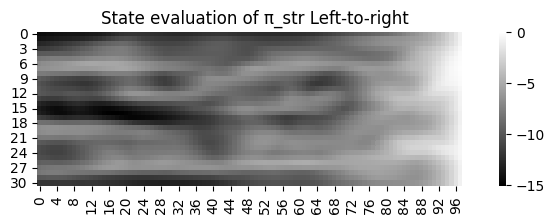

In [188]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(evaluation_ltr, cmap="gray")
plt.title("State evaluation of π_str Left-to-right")
plt.show()

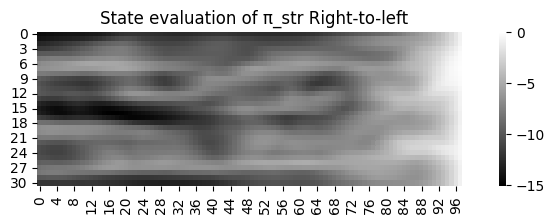

In [189]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(evaluation_rtl, cmap="gray")
plt.title("State evaluation of π_str Right-to-left")
plt.show()

In [190]:
evaluation_rtl == evaluation_ltr

True

------------------------------------------
### 3. (*)

The resulting evaluation are equal, regardless if they are calculated left-to-right or right-to-left. Therefore, the policy evaluation ordering doesn't matter (other than for efficiency reasons, as left-to-right leads to computing the same value multiple times (which can be optimized using memoization)).

------------------------------------------

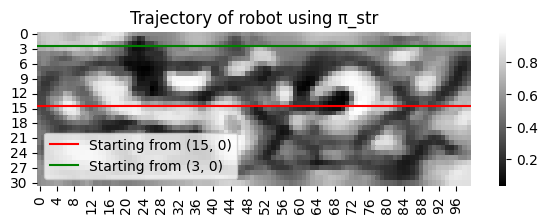

In [191]:
# Plot the trajectory followed by the robot starting from (15, 0) or (3, 0)
plt.figure(figsize=(7,2))
sns.heatmap(mountain.get_map(), cmap="gray")
plt.plot([0, n], [15, 15], c="r", label="Starting from (15, 0)")
plt.plot([0, n], [3, 3], c="g", label="Starting from (3, 0)")
plt.title("Trajectory of robot using π_str")
plt.legend()
plt.show()

The optimal starting row for the policy $\pi_\text{str}$ is equal to the row with the maximal value at column 0.

In [192]:
optimal_starting_row = np.argmax(np.array(evaluation_ltr)[:, 0])
print("Optimal starting row for π_str is", optimal_starting_row)

Optimal starting row for π_str is 7


------------------------------------------
### 7. (*)

No, the two policy evaluations are equal, and therefore we have learned the same thing.

------------------------------------------

The policy $\pi_\text{rnd}$ means that we have a $\frac{1}{3}$ chance of either walking up-right, right or down-right.

Given starting state s = (row, column) = (i, j), the value function can be computed as:

$ v_{\pi_\text{rnd}}(i, j) = \frac{1}{3} * (R((i, j), \text{"upforward"}) + \gamma (v_{\pi_\text{rnd}}(i-1, j+1)) + R((i, j), \text{"forward"}) + \gamma v_{\pi_\text{rnd}}(i, j+1) + R((i, j), \text{"downforward"}) + \gamma v_{\pi_\text{rnd}}(i+1, j+1))$

(*if we are in the middle rows, if we are at either edge row, moving up/down is not allowed and we then only divide by 2).

In [193]:
# Then create the random policy π_rnd
π_rnd = np.array([[[(0.0 if row == 0 or column == n-1 else 0.5 if row == m-1 else 1/3, "upforward"), (0.0 if column == n-1 else 0.5 if row == 0 or row == m-1 else 1/3, "forward"), (0.0 if row == m-1 or column == n-1 else 0.5 if row == 0 else 1/3, "downforward")] for column in range(n)] for row in range(m)], dtype="object")

In [194]:
# Let's run the policy evaluation using this new random policy
evaluation_rnd = [[0] * n for _ in range(m)]
for column in reversed(range(n)):
    for row in range(m):
        state = (row, column)
        for probability, action in π_rnd[state]:
            if probability > 0:
                (next_row, next_column) = mountain.next_state(state, action)
                evaluation_rnd[row][column] += probability * mountain.get_reward(state, action)
                evaluation_rnd[row][column] += probability * gamma * evaluation_rnd[next_row][next_column]

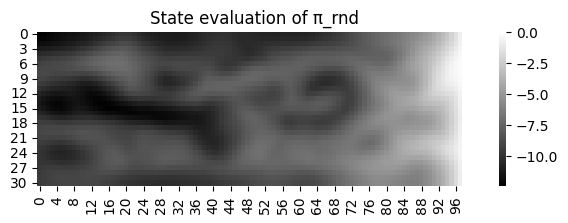

In [195]:
# Let's plot the values as a heatmap
plt.figure(figsize=(7,2))
sns.heatmap(evaluation_rnd, cmap="gray")
plt.title("State evaluation of π_rnd")
plt.show()

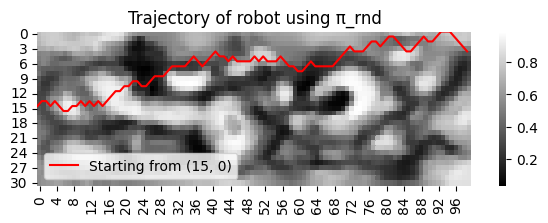

In [196]:
# Sample a trajectory following the random policy
trajectory = [15]
for column in range(n-1):
    current_row = trajectory[column]
    action = np.random.choice(π_rnd[current_row, column, :, 1], p=π_rnd[current_row, column, :, 0].astype(np.float64))
    next_row, _ = mountain.next_state((current_row, column), action)
    trajectory.append(next_row)

# Plot the sample trajectory followed by the robot starting from (15, 0)
# using the random policy
plt.figure(figsize=(7,2))
sns.heatmap(mountain.get_map(), cmap="gray")
plt.plot(np.arange(n), trajectory, c="r", label="Starting from (15, 0)")
plt.title("Trajectory of robot using π_rnd")
plt.legend()
plt.show()

In [197]:
optimal_starting_row = np.argmax(np.array(evaluation_rnd)[:, 0])
print("Optimal starting row for π_rnd is", optimal_starting_row)

Optimal starting row for π_rnd is 8


------------------------------------------
### 10. (*)

Yes, we can see that the policy evaluations are very different! As evaluation of π_str is different from π_rnd then we will have learned something different. We can also see this as the optimal starting row of $\pi_\text{rnd}$ is 8 while for $\pi_\text{str}$ it is 7!

------------------------------------------

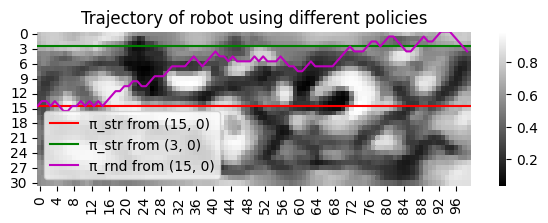

In [198]:
# Plot the trajectory followed by the robot starting from (15, 0) or (3, 0)
plt.figure(figsize=(7,2))
sns.heatmap(mountain.get_map(), cmap="gray")
plt.plot([0, n], [15, 15], c="r", label="π_str from (15, 0)")
plt.plot([0, n], [3, 3], c="g", label="π_str from (3, 0)")
plt.plot(np.arange(n), trajectory, c="m", label="π_rnd from (15, 0)")
plt.title("Trajectory of robot using different policies")
plt.legend()
plt.show()

In [199]:
print("π_str((15, 0)): %.4f" %evaluation_ltr[15][0])
print("π_str((3, 0)): %.4f" %evaluation_ltr[3][0])
print("π_rnd((15, 0)): %.4f" %evaluation_rnd[15][0])

π_str((15, 0)): -13.4682
π_str((3, 0)): -11.6771
π_rnd((15, 0)): -10.9669


------------------------------------------
### 11. (*)

If the robot can choose its initial position and policy, the optimal choice would be $\pi_\text{rnd}$ and starting row 15. This is because $\pi_\text{rnd}((15, 0)) \approx -10.6996$ which is slightly higher than the other $\pi_\text{str}((15, 0)) \approx -13.4682$ and $\pi_\text{str}((3, 0)) \approx -11.6771$.

------------------------------------------

As we can see, following a single action without any exploration makes the evaluation a bit worse! Therefore, exploration is slightly affecting the final results. Using $\pi_\text{rnd}$ which adds a lot of exploration, leads to the evaluation being a bit higher.